### VAR (Autoregressive)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

In [ ]:
# VAR Model for MNIST with Linear Layers
class MNISTVARModel(nn.Module):
    def __init__(self, input_dim, lag_order=5, hidden_dims=[512, 256, 128]):
        super(MNISTVARModel, self).__init__()
        self.input_dim = input_dim
        self.lag_order = lag_order
        
        # Flatten the lagged sequences: lag_order * input_dim
        self.flattened_dim = lag_order * input_dim
        
        # Linear layers for VAR modeling
        layers = []
        prev_dim = self.flattened_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.3)
            ])
            prev_dim = hidden_dim
        
        self.encoder = nn.Sequential(*layers)
        
        # Output layer to predict all variables (pixels)
        self.output_layer = nn.Sequential(
            nn.Linear(prev_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, input_dim),
            nn.Tanh()  # Output in range [-1, 1] for normalized images
        )
        
    def forward(self, x):
        # x shape: (batch_size, lag_order, input_dim)
        batch_size = x.shape[0]
        
        # Flatten the lagged sequences
        x_flat = x.view(batch_size, -1)  # (batch_size, lag_order * input_dim)
        
        # Process through linear layers
        encoded = self.encoder(x_flat)
        
        # Predict next time step (next MNIST image)
        prediction = self.output_layer(encoded)  # (batch_size, input_dim)
        
        return prediction

In [ ]:
# MNIST VAR Trainer
class MNISTVARTrainer:
    def __init__(self, model, lr=0.001):
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
        self.criterion = nn.MSELoss()
        self.scaler = StandardScaler()
    
    def create_mnist_sequences(self, data, labels, lag_order, sequence_length=1000):
        """Create sequential sequences from MNIST data"""
        # Treat different MNIST samples as sequential time steps
        sequences = []
        targets = []
        
        # Use first sequence_length samples to create sequences
        data_subset = data[:sequence_length + lag_order]
        
        for i in range(len(data_subset) - lag_order):
            seq = data_subset[i:i+lag_order]  # (lag_order, input_dim)
            target = data_subset[i+lag_order]  # (input_dim)
            sequences.append(seq)
            targets.append(target)
        
        return torch.FloatTensor(np.array(sequences)), torch.FloatTensor(np.array(targets))
    
    def prepare_mnist_data(self, batch_size=64, train_ratio=0.8):
        """Load and prepare MNIST data for VAR modeling"""
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),  # Normalize to [-1, 1]
            transforms.Lambda(lambda x: x.view(-1))  # Flatten images
        ])
        
        # Load MNIST dataset
        train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
        
        # Combine train and test for more sequential data
        all_data = torch.cat([train_dataset.data, test_dataset.data])
        all_labels = torch.cat([train_dataset.targets, test_dataset.targets])
        
        # Convert to numpy and normalize
        all_data = all_data.float() / 255.0  # Normalize to [0, 1]
        all_data = all_data.numpy()
        all_labels = all_labels.numpy()
        
        # Flatten images
        all_data_flat = all_data.reshape(len(all_data), -1)
        
        # Create sequences
        sequences, targets = self.create_mnist_sequences(all_data_flat, all_labels, self.model.lag_order)
        
        # Split into train and test
        split_idx = int(len(sequences) * train_ratio)
        
        X_train, X_test = sequences[:split_idx], sequences[split_idx:]
        y_train, y_test = targets[:split_idx], targets[split_idx:]
        
        print(f"Created {len(X_train)} training sequences and {len(X_test)} test sequences")
        print(f"Input shape: {X_train.shape}, Target shape: {y_train.shape}")
        
        return (X_train, y_train, X_test, y_test), all_data, all_labels
    
    def train(self, epochs=100, patience=10):
        """Train the VAR model with early stopping"""
        # Prepare data
        (X_train, y_train, X_test, y_test), original_data, labels = self.prepare_mnist_data()
        
        train_losses = []
        test_losses = []
        best_test_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(epochs):
            # Training
            self.model.train()
            self.optimizer.zero_grad()
            
            train_predictions = self.model(X_train)
            train_loss = self.criterion(train_predictions, y_train)
            train_loss.backward()
            self.optimizer.step()
            
            # Validation
            self.model.eval()
            with torch.no_grad():
                test_predictions = self.model(X_test)
                test_loss = self.criterion(test_predictions, y_test)
            
            train_losses.append(train_loss.item())
            test_losses.append(test_loss.item())
            
            # Early stopping
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                patience_counter = 0
                torch.save(self.model.state_dict(), 'best_mnist_var_model.pth')
            else:
                patience_counter += 1
            
            if epoch % 10 == 0:
                print(f'Epoch {epoch:3d}/{epochs}: Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')
            
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch}')
                break
        
        # Load best model
        self.model.load_state_dict(torch.load('best_mnist_var_model.pth'))
        
        return train_losses, test_losses, (X_train, y_train, X_test, y_test), original_data, labels
    
    @torch.no_grad()
    def predict_sequence(self, initial_sequence, steps=10):
        """Generate a sequence of predictions"""
        self.model.eval()
        
        predictions = []
        current_sequence = initial_sequence.clone()
        
        for _ in range(steps):
            # Get prediction for next time step
            pred = self.model(current_sequence.unsqueeze(0)).squeeze(0)
            predictions.append(pred.numpy())
            
            # Update sequence: remove oldest, add new prediction
            current_sequence = torch.cat([current_sequence[1:], pred.unsqueeze(0)])
        
        return np.array(predictions)
    
    @torch.no_grad()
    def reconstruct_images(self, test_sequences, num_samples=5):
        """Reconstruct images using the VAR model"""
        self.model.eval()
        
        reconstructions = []
        original_images = []
        
        for i in range(num_samples):
            # Get test sequence and target
            test_seq = test_sequences[i].unsqueeze(0)
            target_img = test_sequences[i+1][-1]  # The actual next image
            
            # Predict next image
            pred_img = self.model(test_seq).squeeze(0)
            
            reconstructions.append(pred_img.numpy())
            original_images.append(target_img.numpy())
        
        return np.array(reconstructions), np.array(original_images)

In [ ]:
# Visualization functions for MNIST
def plot_mnist_training_curves(train_losses, test_losses):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('MNIST VAR Model Training Progress')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.semilogy(train_losses, label='Training Loss (log)')
    plt.semilogy(test_losses, label='Test Loss (log)')
    plt.title('Training Progress (Log Scale)')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss (log)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('mnist_var_training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
def plot_mnist_reconstructions(reconstructions, originals, num_samples=5):
    """Plot original MNIST images vs reconstructions"""
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    
    for i in range(num_samples):
        # Original image
        orig_img = originals[i].reshape(28, 28)
        axes[0, i].imshow(orig_img, cmap='gray')
        axes[0, i].set_title(f'Original {i+1}')
        axes[0, i].axis('off')
        
        # Reconstructed image
        recon_img = reconstructions[i].reshape(28, 28)
        axes[1, i].imshow(recon_img, cmap='gray')
        axes[1, i].set_title(f'Reconstructed {i+1}')
        axes[1, i].axis('off')
    
    plt.suptitle('MNIST VAR Model: Original vs Reconstructed Images')
    plt.tight_layout()
    plt.savefig('mnist_var_reconstructions.png', dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
def plot_sequence_generation(initial_sequence, generated_sequence, original_data, lag_order):
    """Plot the sequence generation process"""
    num_steps = len(generated_sequence)
    fig, axes = plt.subplots(2, num_steps + 1, figsize=(15, 6))
    
    # Plot initial sequence (lag_order images)
    for i in range(lag_order):
        img = initial_sequence[i].reshape(28, 28)
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f'Initial {i+1}')
        axes[0, i].axis('off')
    
    axes[0, lag_order].axis('off')
    
    # Plot generated sequence
    for i in range(num_steps):
        img = generated_sequence[i].reshape(28, 28)
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].set_title(f'Generated {i+1}')
        axes[1, i].axis('off')
    
    axes[1, num_steps].axis('off')
    
    plt.suptitle('MNIST VAR Sequence Generation')
    plt.tight_layout()
    plt.savefig('mnist_var_sequence_generation.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
def plot_pixel_correlations(original_data, sample_size=1000):
    """Plot correlation between different pixel regions"""
    # Use a subset of data
    data_subset = original_data[:sample_size].reshape(sample_size, -1)
    
    # Calculate correlation matrix for a subset of pixels
    pixel_indices = np.random.choice(data_subset.shape[1], 100, replace=False)
    corr_matrix = np.corrcoef(data_subset[:, pixel_indices].T)
    
    plt.figure(figsize=(10, 8))
    im = plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(im)
    plt.title('Pixel Correlation Matrix (100 random pixels)')
    plt.xlabel('Pixel Index')
    plt.ylabel('Pixel Index')
    
    plt.tight_layout()
    plt.savefig('mnist_pixel_correlations.png', dpi=300, bbox_inches='tight')
    plt.show()


VAR Model for MNIST with Linear Layers
Model Architecture:
- Input dimension: 784 (28x28 MNIST images)
- Lag order: 5
- Hidden dimensions: [1024, 512, 256]
- Total parameters: 4,938,512

Training MNIST VAR model...
Created 800 training sequences and 200 test sequences
Input shape: torch.Size([800, 5, 784]), Target shape: torch.Size([800, 784])
Epoch   0/100: Train Loss: 0.110894, Test Loss: 0.111440
Epoch  10/100: Train Loss: 0.074212, Test Loss: 0.072380
Epoch  20/100: Train Loss: 0.067571, Test Loss: 0.068343
Epoch  30/100: Train Loss: 0.065005, Test Loss: 0.068498
Early stopping at epoch 35

Training completed!
Final Training Loss: 0.064401
Final Test Loss: 0.068518


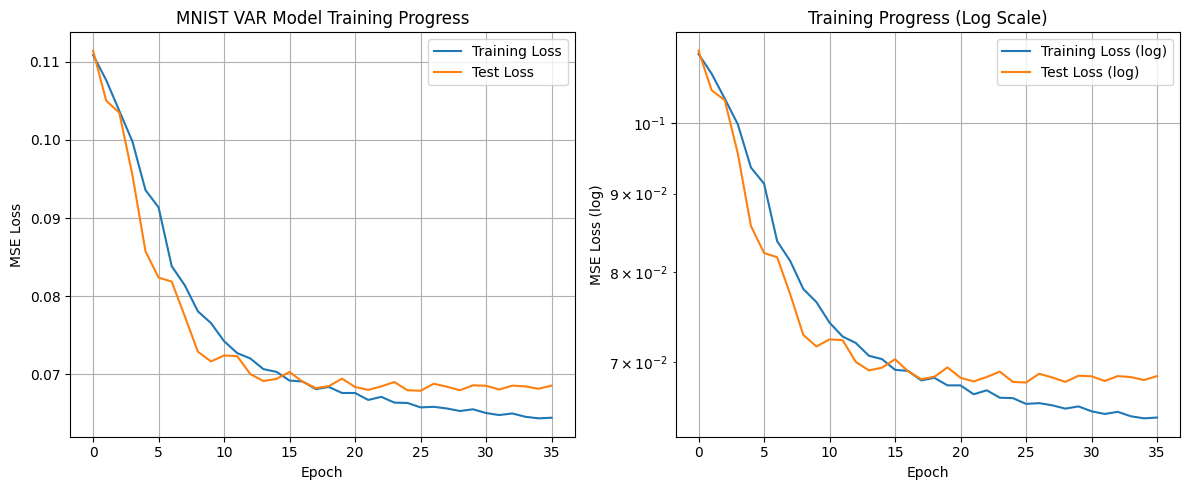

/home/nyathi/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nyathi/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


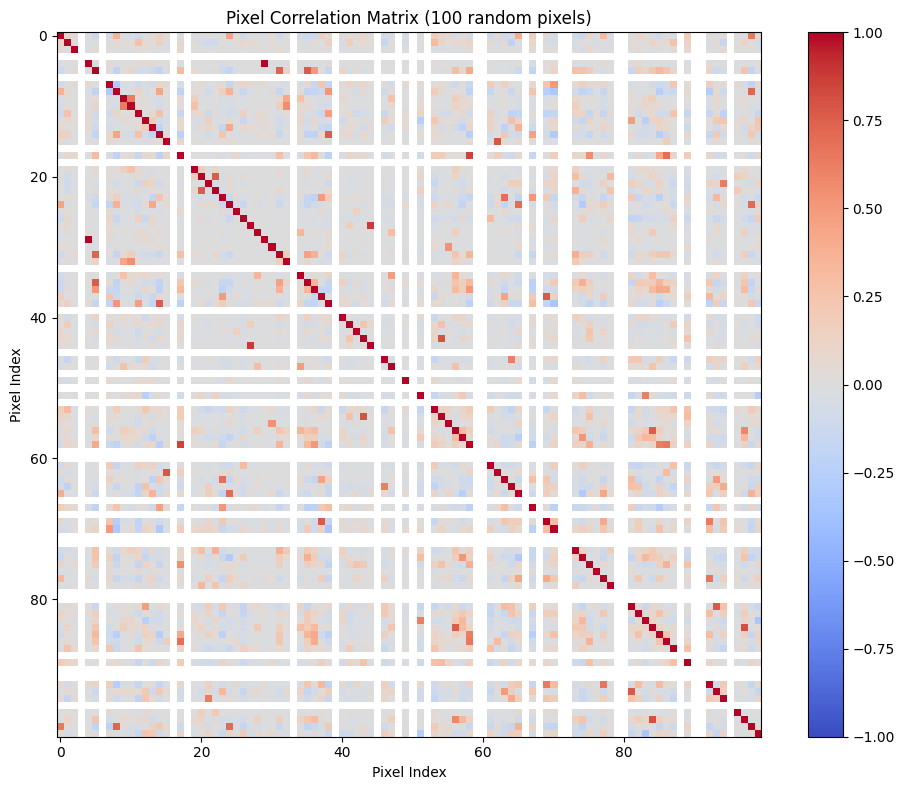


Generating image reconstructions...


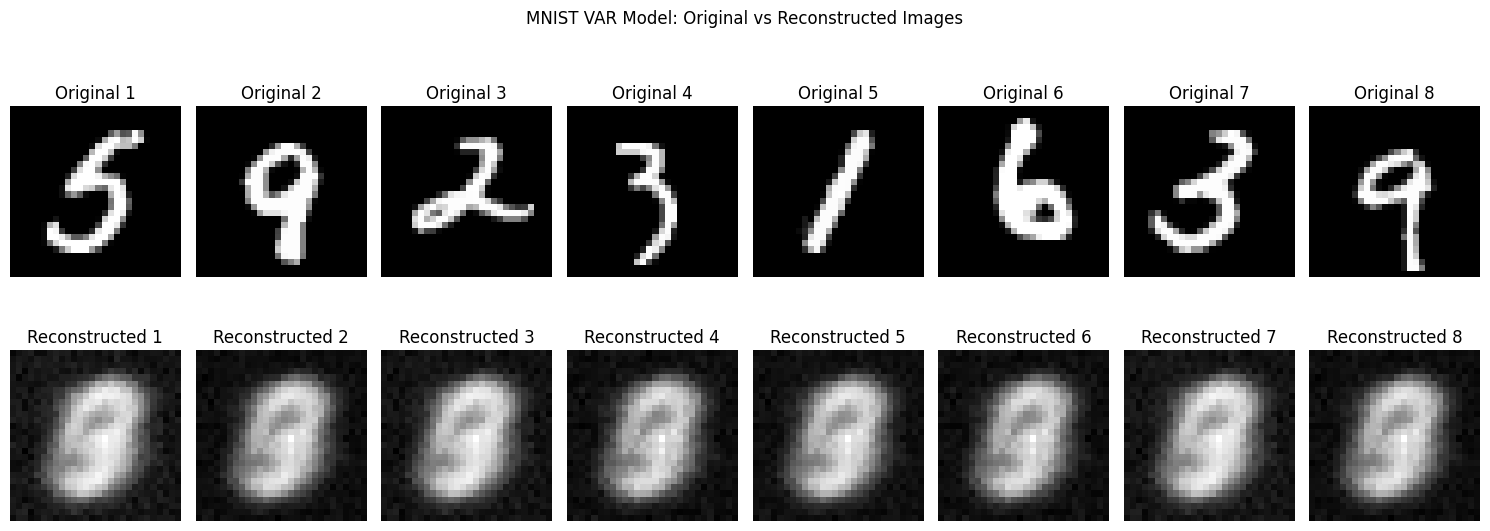

Generating image sequence...


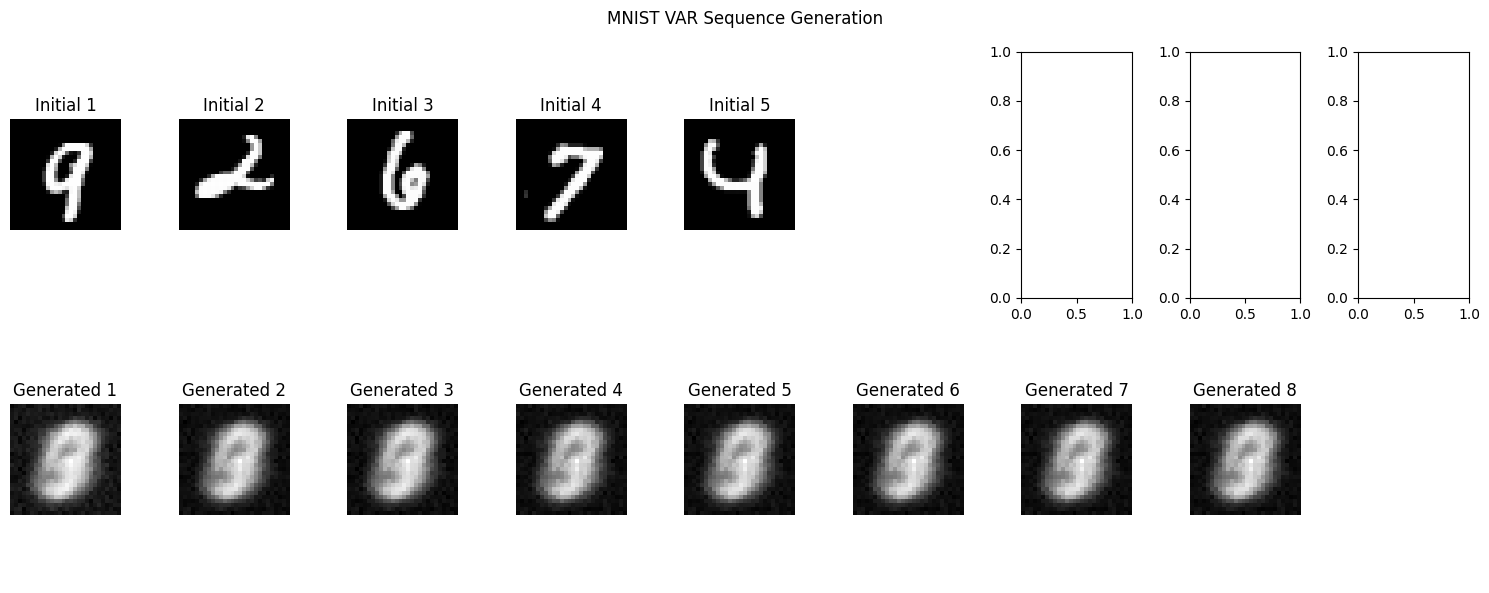


Statistical Summary:
Best training loss: 0.064324
Best test loss: 0.067863
Average reconstruction MSE: 0.060583

Sample Pixel-wise Comparison (first 10 pixels):
Pixel 0: Pred -0.040, Actual 0.000, Diff 0.040
Pixel 1: Pred -0.010, Actual 0.000, Diff 0.010
Pixel 2: Pred 0.012, Actual 0.000, Diff 0.012
Pixel 3: Pred 0.026, Actual 0.000, Diff 0.026
Pixel 4: Pred -0.030, Actual 0.000, Diff 0.030
Pixel 5: Pred -0.028, Actual 0.000, Diff 0.028
Pixel 6: Pred 0.011, Actual 0.000, Diff 0.011
Pixel 7: Pred 0.029, Actual 0.000, Diff 0.029
Pixel 8: Pred 0.016, Actual 0.000, Diff 0.016
Pixel 9: Pred 0.022, Actual 0.000, Diff 0.022


In [ ]:
# Main execution
def main():
    print("VAR Model for MNIST with Linear Layers")
    print("=" * 50)
    
    # Model parameters
    input_dim = 28 * 28  # MNIST image size
    lag_order = 5  # How many past images to use for prediction
    hidden_dims = [1024, 512, 256]  # Linear layer dimensions
    
    # Initialize model and trainer
    model = MNISTVARModel(input_dim=input_dim, lag_order=lag_order, hidden_dims=hidden_dims)
    
    trainer = MNISTVARTrainer(model, lr=0.001)
    
    print(f"Model Architecture:")
    print(f"- Input dimension: {input_dim} (28x28 MNIST images)")
    print(f"- Lag order: {lag_order}")
    print(f"- Hidden dimensions: {hidden_dims}")
    print(f"- Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    print()
    
    # Train the model
    print("Training MNIST VAR model...")
    train_losses, test_losses, (X_train, y_train, X_test, y_test), original_data, labels = trainer.train(epochs=100)
    
    print(f"\nTraining completed!")
    print(f"Final Training Loss: {train_losses[-1]:.6f}")
    print(f"Final Test Loss: {test_losses[-1]:.6f}")
    
    # Plot training results
    plot_mnist_training_curves(train_losses, test_losses)
    
    # Plot pixel correlations
    plot_pixel_correlations(original_data)
    
    # Generate reconstructions
    print("\nGenerating image reconstructions...")
    reconstructions, originals = trainer.reconstruct_images(X_test, num_samples=8)
    plot_mnist_reconstructions(reconstructions, originals, num_samples=8)
    
    # Generate sequence
    print("Generating image sequence...")
    initial_sequence = X_test[0]  # First test sequence
    generated_sequence = trainer.predict_sequence(initial_sequence, steps=8)
    plot_sequence_generation(initial_sequence, generated_sequence, original_data, lag_order)
    
    # Statistical analysis
    print(f"\nStatistical Summary:")
    print(f"Best training loss: {min(train_losses):.6f}")
    print(f"Best test loss: {min(test_losses):.6f}")
    
    # Calculate reconstruction quality
    mse_reconstruction = np.mean((reconstructions - originals) ** 2)
    print(f"Average reconstruction MSE: {mse_reconstruction:.6f}")
    
    # Show sample predictions vs actuals
    print(f"\nSample Pixel-wise Comparison (first 10 pixels):")
    sample_pred = reconstructions[0][:10]
    sample_actual = originals[0][:10]
    
    for i in range(10):
        print(f"Pixel {i}: Pred {sample_pred[i]:.3f}, Actual {sample_actual[i]:.3f}, Diff {abs(sample_pred[i]-sample_actual[i]):.3f}")

if __name__ == "__main__":
    main()